## Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#data = pd.read_csv('test.csv', sep = ",")
data = pd.read_csv('/Users/faissalfarid/Desktop/bachelorarbeit/datasets/mainData/data_0.2_clean.csv', parse_dates=[1])
#data = pd.read_csv('test.csv',index_col=[2],  parse_dates=[1])

#filter dataset to specific chargingstation/street
#data = data[(data['chargingstart'].dt.year >=2020)]
data = data[(data['street'] == 'Notkestr.')]
#data = data[(data['latitude'] == 53.555549)]

data_time = data

In [2]:
#data = data[(data['street'] == 'Notkestr.')]
#data = data[(data['latitude'] == 53.574459)]
print(data['longitude'].unique())
print(data['latitude'].unique())
#data
#data1 = data[(data['longitude'] == 10.01623)]
#data2 = data[(data['longitude'] == 10.01013)]

[9.881837]
[53.574459]


## Add new Features

In [3]:
#convert into datetime
#data['chargingstart'] = pd.to_datetime(data['chargingstart'])
#data['chargingstop'] = pd.to_datetime(data['chargingstop'])
#sort data by date
#data = data.sort_values(by=['chargingstart'])
#calculate chargingtime
#data['chargingtime'] = (data['chargingstop'] - data['chargingstart'])
#data['chargingtime'] = pd.to_timedelta(data['chargingtime'])
#data['chargingtime'] = data['chargingtime'].dt.total_seconds().div(60).astype(int)
#calculate chargedenergy
#data['chargedeneergy'] = data['meterstart'] - data['meterstop']
# filter chargingtime < 2 Values 
#data = data[(data['chargingtime'] > 1)]
#filter chargingstart < 2015 Values 
#data = data[(data['chargingstart'].dt.year >=2015)]
#filter only stations in hamburg 
#data = data[(data['city'] == 'Hamburg')]



## find most used value

In [4]:
#print most values in specific collum 
item_counts = data["street"].value_counts(normalize=True)
item_counts

Notkestr.    1.0
Name: street, dtype: float64

## detect anomalys/outliers in dataset

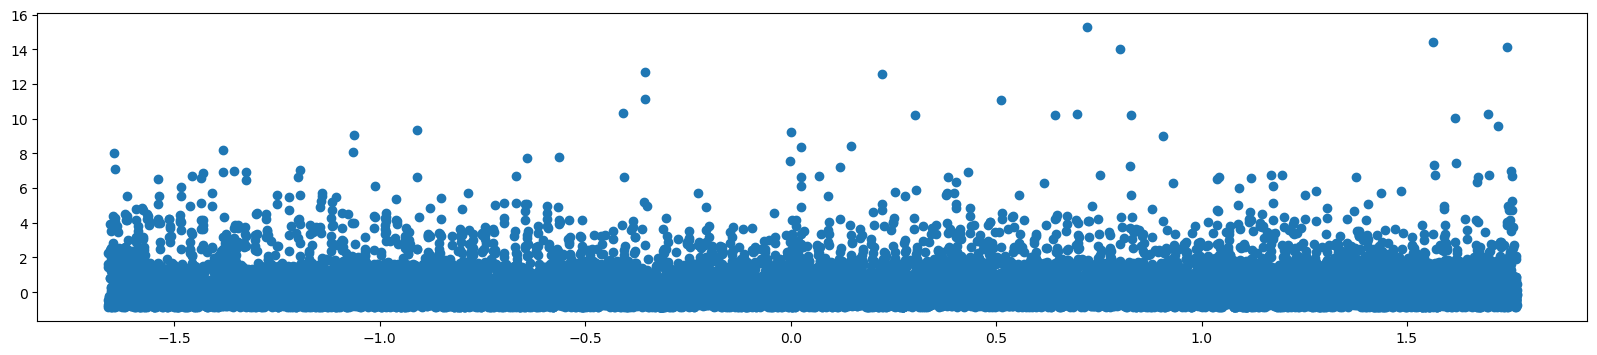

DBSCAN(eps=0.25, min_samples=10)
anomalys =  159


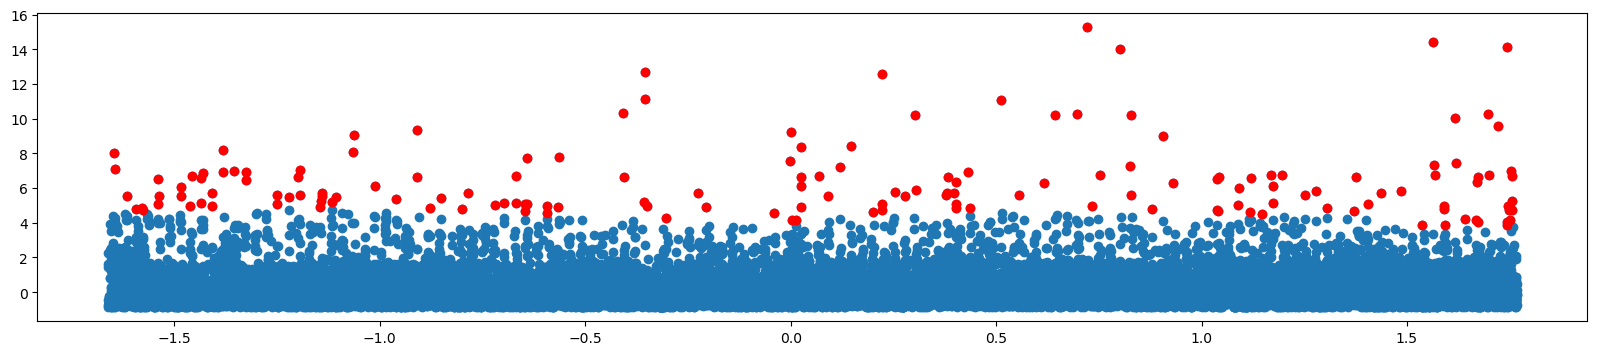

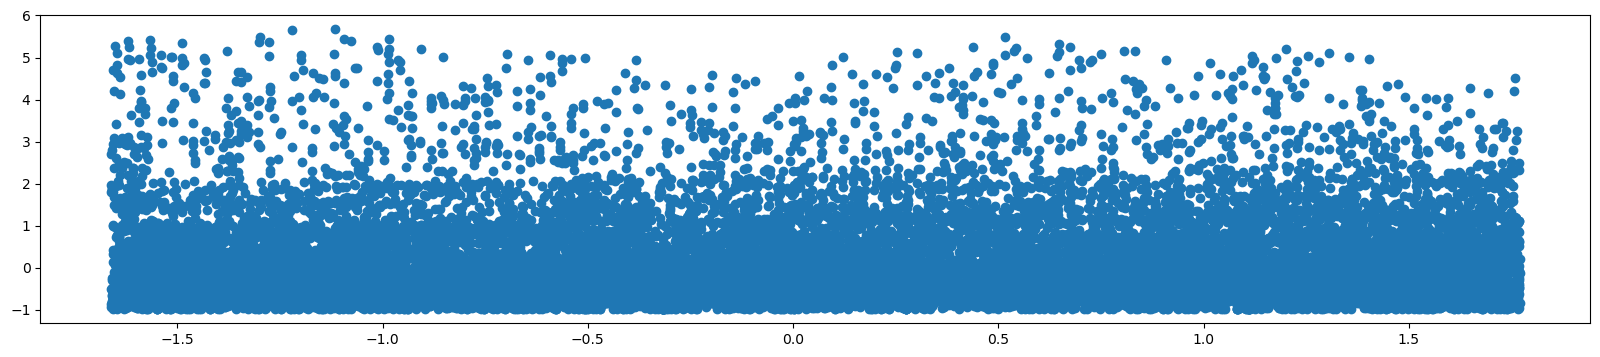

DBSCAN(eps=0.25, min_samples=10)
anomalys =  13


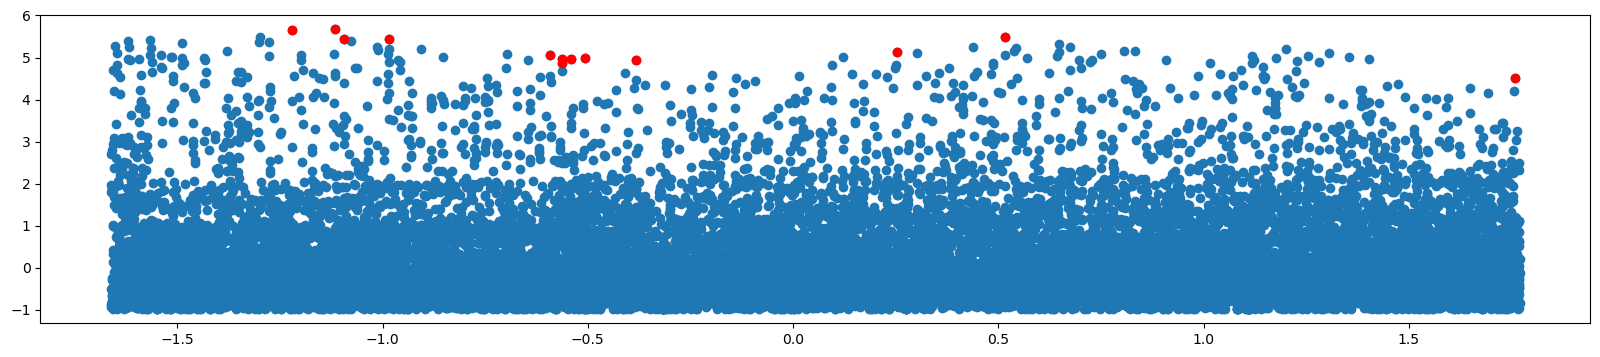

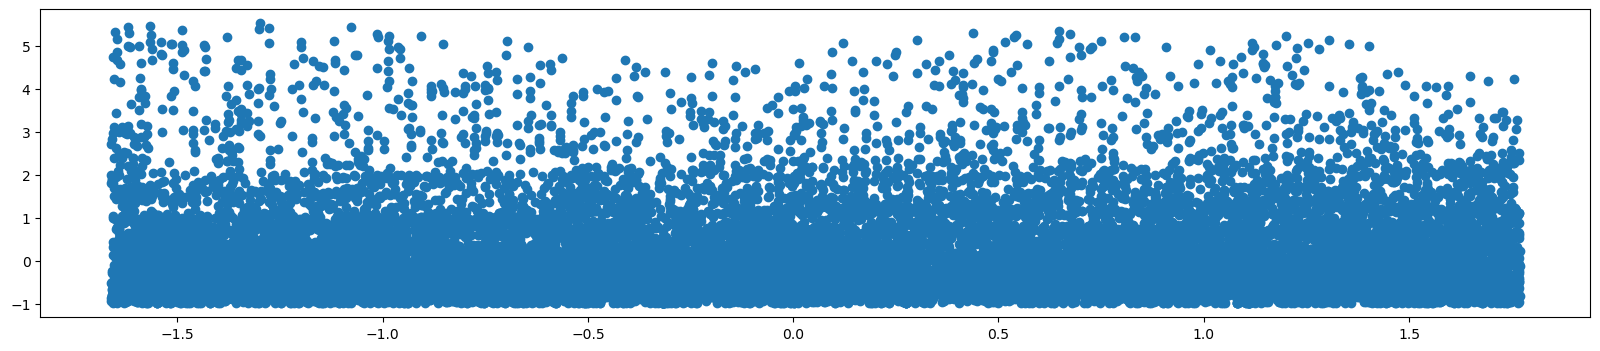

DBSCAN(eps=0.25, min_samples=10)
anomalys =  0


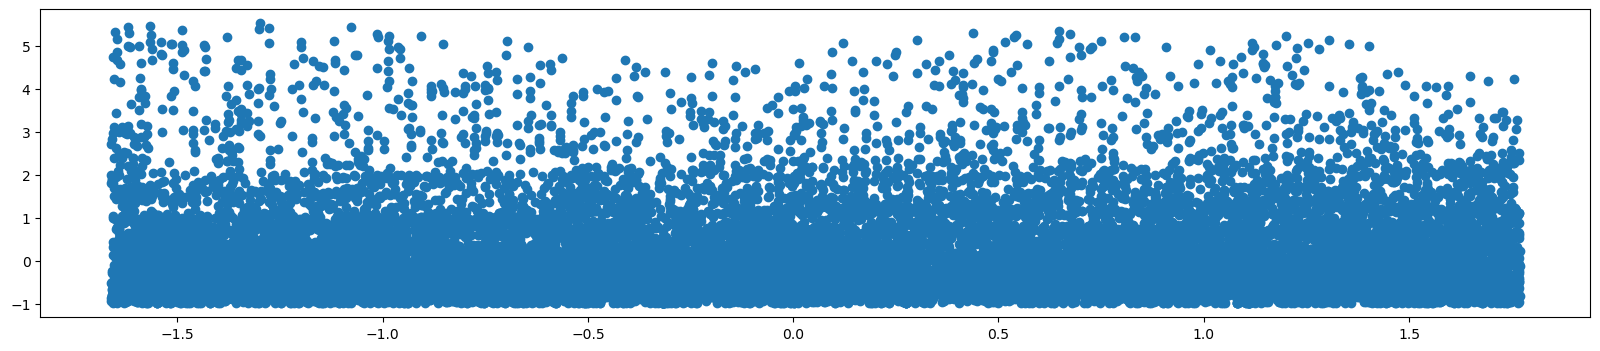

In [5]:
import numpy as np 
from numpy import random, where
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pylab import rcParams
#rcParams['figure.figsize'] = 14,6
rcParams['figure.figsize'] = 20,4

INIT = 1
anom_index = INIT

# Do the process so long until no anomaly were detected
while(np.count_nonzero(anom_index)>0):
    #prepare data for model 
    dbscan_data = data[['chargingstart', 'chargingtime']]

    #cause dbscan acept only floats make chargingstart numeric
    dbscan_data['chargingstart']= pd.to_numeric(dbscan_data['chargingstart'])

    #dbscan_data = dbscan_data.values.astype('float32', copy=False)
    dbscan_data
    #normalize Data 
    dbscan_data_scaler = StandardScaler().fit(dbscan_data)
    dbscan_data = dbscan_data_scaler.transform(dbscan_data)
    X = dbscan_data

    plt.scatter(X[:,0], X[:,1])
    plt.show()

    clustering = DBSCAN(eps=1, min_samples=1).fit(X)
    clustering.labels_
    dbscan = DBSCAN(eps = 0.25, min_samples = 10)
    print(dbscan)

    pred = dbscan.fit_predict(X)
    anom_index = where(pred == -1)
    print("anomalys = ", np.count_nonzero(anom_index))
    values = X[anom_index]

    plt.scatter(X[:,0], X[:,1])
    plt.scatter(values[:,0], values[:,1], color='r')
    plt.show()

#################Mark all Anomalys##################
    ANOMALY = 888
    lenArr = np.count_nonzero(anom_index)    
    for i in range(lenArr):
        data.iloc[anom_index[0][i],data.columns.get_loc('longitude')] = ANOMALY
        data_time.iloc[anom_index[0][i],data_time.columns.get_loc('longitude')] = ANOMALY
        
#################Filter Anomalys##################        
    data = data[(data['longitude'] !=ANOMALY)]    
    data_time = data_time[(data_time['longitude'] !=ANOMALY)]  

## safe filtered dataset

In [6]:
data.to_csv('anomalyFilteredData.csv')

## resample data to hour and sum chargingtimes

In [9]:
##########HHHHHHHHHOOOOOOUUUUUURRRRLLLLLYY#################

##load Data and set index to chargingstart 
data = pd.read_csv('anomalyFilteredData.csv',parse_dates=[2], index_col=[2])

#resample and sum chargingtime
data = data.resample('H').agg(dict(chargingtime='sum'))

#safe resampled dataset

for i in range(len(data)-1):
    chargingtime = data.iloc[i,data.columns.get_loc('chargingtime')]
    if(chargingtime>120):
        data.iloc[i,data.columns.get_loc('chargingtime')] = 120
        data.iloc[i+1,data.columns.get_loc('chargingtime')] = chargingtime-120
        
data.to_csv('hourly_ReaampleAndFilteredData.csv') 

##########DDDDDDAAAAAAAAAIIIIIIIILLLLLLYYYYY#################


##load Data and set index to chargingstart 
daily_data = pd.read_csv('anomalyFilteredData.csv',parse_dates=[2], index_col=[2])

#resample and sum chargingtime
daily_data = daily_data.resample('D').agg(dict(chargingtime='sum'))

#safe resampled dataset

for i in range(len(daily_data)-1):
    chargingtime = daily_data.iloc[i,daily_data.columns.get_loc('chargingtime')]
    if(chargingtime>1440):
        daily_data.iloc[i,daily_data.columns.get_loc('chargingtime')] = 1440
        daily_data.iloc[i+1,daily_data.columns.get_loc('chargingtime')] = chargingtime-1440
        
daily_data.to_csv('daily_dataReaampleAndFilteredData.csv')

## calc occupation and distributing the occupation
    

In [11]:
#load Data 
data = pd.read_csv('hourly_ReaampleAndFilteredData.csv')

#calc occ
LADEPUNKTE = 2 #EVSES
data['occupation'] = (data['chargingtime'] / (LADEPUNKTE*60))
data.to_csv('hourly_ResampleAndFilterAndDistrubutingOcc.csv')  

#for i in range(len(data)-1):
#    occupation = data.iloc[i,data.columns.get_loc('occupation')]
#    if(occupation>1):
#        diffOcc = occupation-1
#        data.iloc[i,data.columns.get_loc('occupation')] =1
#        data.iloc[i+1,data.columns.get_loc('occupation')] = diffOcc + data.iloc[i+1,data.columns.get_loc('occupation')]
#        
#data.to_csv('ResampleAndFilterAndDistrubutingOcc.csv')    

#load Data 
data = pd.read_csv('daily_dataReaampleAndFilteredData.csv')

#calc occ
LADEPUNKTE = 2 #EVSES
data['occupation'] = (data['chargingtime'] / (LADEPUNKTE*60))
data.to_csv('daily_ResampleAndFilterAndDistrubutingOcc.csv')  

#for i in range(len(data)-1):
#    occupation = data.iloc[i,data.columns.get_loc('occupation')]
#    if(occupation>1):
#        diffOcc = occupation-1
#        data.iloc[i,data.columns.get_loc('occupation')] =1
#        data.iloc[i+1,data.columns.get_loc('occupation')] = diffOcc + data.iloc[i+1,data.columns.get_loc('occupation')]
#        
#data.to_csv('ResampleAndFilterAndDistrubutingOcc.csv')    

## merge mainData and wetherData

In [12]:
##########HHHHHHHOOOOOOOUUUUURRRRLLLLLLYYYYYYY##########

#load wether data
wetherData = pd.read_csv('/Users/faissalfarid/Desktop/bachelorarbeit/datasets/wetherdata/fühlsbüttel/wetherMergepreception.csv')
#load Main Data
mainData = pd.read_csv('hourly_ResampleAndFilterAndDistrubutingOcc.csv')
#rename collum for wetherdata same like mainData for merging
wetherData.rename(columns={'MESS_DATUM': 'chargingstart'}, inplace=True)
mainData['chargingstart'] = pd.to_datetime(mainData['chargingstart'])
wetherData['chargingstart'] = pd.to_datetime(wetherData['chargingstart'])

mainData['chargingstart'] = pd.to_datetime(mainData['chargingstart'], utc = True)
wetherData['chargingstart'] = pd.to_datetime(wetherData['chargingstart'], utc = True)

mergedData = pd.merge(mainData, wetherData, on="chargingstart",how="left")
mergedData.to_csv('hourly_MainData_merge_WetherData.csv')



##########DDDDAAAAAAIIIIIIILLLLLYYYYY##########

#load wether data
wetherData = pd.read_csv('/Users/faissalfarid/Desktop/bachelorarbeit/datasets/wetherdata/fühlsbüttel/wetherMergepreception.csv')
#load Main Data
mainData = pd.read_csv('daily_ResampleAndFilterAndDistrubutingOcc.csv')
#rename collum for wetherdata same like mainData for merging
wetherData.rename(columns={'MESS_DATUM': 'chargingstart'}, inplace=True)
mainData['chargingstart'] = pd.to_datetime(mainData['chargingstart'])
wetherData['chargingstart'] = pd.to_datetime(wetherData['chargingstart'])

mainData['chargingstart'] = pd.to_datetime(mainData['chargingstart'], utc = True)
wetherData['chargingstart'] = pd.to_datetime(wetherData['chargingstart'], utc = True)

mergedData = pd.merge(mainData, wetherData, on="chargingstart",how="left")
mergedData.to_csv('daily_MainData_merge_WetherData.csv')

## Feature Engeneering -> create new Features

In [7]:
#######HHHHHHHHOOOOOOUUUURRRRRLLLLLYYYYYYY#########
import pandas as pd 
#load Data
data = pd.read_csv('hourly_MainData_merge_WetherData.csv')
data['chargingstart'] = pd.to_datetime(data['chargingstart'])
#dates
data['date'] = data.chargingstart
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dayofyear'] = data['date'].dt.dayofyear
data['dayofmonth'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.weekofyear

#occupation

#calcuate binary occupation
data['binaryOcc'] = data['occupation'] < 0.5

#calcutae categorie occupation
data['categorieOcc'] = 1

for i in range(len(data)):
    occ = data.iloc[i,data.columns.get_loc('occupation')]
    
    if(occ >= 0.4):
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 1
    elif(occ >= 0.4):
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 2 
    elif(occ >= 0.4): 
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 3
    elif(occ >= 0.4):  
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 4
    else:
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 5
data = data[(data['chargingstart']<="2021-04-06 23:00:00")]
data.to_csv('hourly_finalData.csv')        


#######DDDDDDAAAAAAAIIIIIIILLLLLLYYYYYYY#########

#load Data
data = pd.read_csv('daily_MainData_merge_WetherData.csv')
data['chargingstart'] = pd.to_datetime(data['chargingstart'])
#dates
data['date'] = data.chargingstart
data['dayofweek'] = data['date'].dt.dayofweek
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dayofyear'] = data['date'].dt.dayofyear
data['dayofmonth'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.weekofyear

#occupation

#calcuate binary occupation
data['binaryOcc'] = data['occupation'] < 0.5

#calcutae categorie occupation
data['categorieOcc'] = 1

for i in range(len(data)):
    occ = data.iloc[i,data.columns.get_loc('occupation')]
    
    if(occ >= 0.4):
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 1
    elif(occ >= 0.4):
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 2 
    elif(occ >= 0.4): 
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 3
    elif(occ >= 0.4):  
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 4
    else:
        data.iloc[i,data.columns.get_loc('categorieOcc')] = 5
data = data[(data['chargingstart']<="2021-04-06 23:00:00")]
data.to_csv('daily_finalData.csv')        

/Users/faissalfarid/opt/anaconda3/envs/Uni/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
/Users/faissalfarid/opt/anaconda3/envs/Uni/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [8]:
#bei corr problemem anwenden
a = data
a['occupation'] = data['occupation']*100
a['occupation'] = a['occupation'].astype(int)

In [10]:
a

,Unnamed: 0,Unnamed: 0_x,chargingstart,chargingtime,occupation,Unnamed: 0_y,TT_TU,RF_TU,R1,RS_IND,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,binaryOcc,categorieOcc
0,0,0,2018-10-08 00:00:00+00:00,1440,1200,33024.0,3.7,96.0,0.0,0.0,2018-10-08 00:00:00+00:00,0,4,10,2018,281,8,41,False,1
1,1,1,2018-10-09 00:00:00+00:00,387,322,33048.0,8.2,84.0,0.0,0.0,2018-10-09 00:00:00+00:00,1,4,10,2018,282,9,41,False,1
2,2,2,2018-10-10 00:00:00+00:00,1440,1200,33072.0,7.3,95.0,0.0,0.0,2018-10-10 00:00:00+00:00,2,4,10,2018,283,10,41,False,1
3,3,3,2018-10-11 00:00:00+00:00,1440,1200,33096.0,14.1,80.0,0.0,0.0,2018-10-11 00:00:00+00:00,3,4,10,2018,284,11,41,False,1
4,4,4,2018-10-12 00:00:00+00:00,1440,1200,33120.0,11.9,75.0,0.0,0.0,2018-10-12 00:00:00+00:00,4,4,10,2018,285,12,41,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,907,907,2021-04-02 00:00:00+00:00,1440,1200,54792.0,2.3,95.0,0.0,0.0,2021-04-02 00:00:00+00:00,4,2,4,2021,92,2,13,False,1
908,908,908,2021-04-03 00:00:00+00:00,1440,1200,54816.0,2.7,90.0,0.0,0.0,2021-04-03 00:00:00+00:00,5,2,4,2021,93,3,13,False,1
909,909,909,2021-04-04 00:00:00+00:00,490,408,54840.0,1.4,96.0,0.0,0.0,2021-04-04 00:00:00+00:00,6,2,4,2021,94,4,13,False,1
910,910,910,2021-04-05 00:00:00+00:00,1440,1200,54864.0,5.5,77.0,0.0,0.0,2021-04-05 00:00:00+00:00,0,2,4,2021,95,5,14,False,1


In [11]:
a['period'] = (a['hour'].dt.hour % 24 + 4) // 4
a['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

KeyError: 'hour'

In [ ]:
import matplotlib.pyplot as plt
plt.plot(s['date'], s['chargingtime'])
data = data.reset_index() 

In [15]:
hourly_data = pd.read_csv('hourly_finalData.csv')
daily_data = pd.read_csv('daily_finalData.csv')